# Bounding box detection - Racoon data


## Data files
- images_racoon.rar: contain images of racoons
- train_labels.cv: contains coordinates for bounding box for every image

### Import the necessary libraries

In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
# IMPORT LIBRARIES AND PACKAGES
import tensorflow as tf
import csv
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from tensorflow.keras import Model
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.layers import Conv2D, Reshape
from tensorflow.keras.utils import Sequence
from tensorflow.keras.backend import epsilon

### Change directory

In [49]:
import os
os.chdir('/content/drive/My Drive/Paridhi_Colab/Internal_lab_13sept')

### Load the training data from train.csv file

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving train_labels.csv to train_labels (1).csv


In [50]:
df = pd.read_csv('train_labels.csv')
df.head(5)

,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-17.jpg,259,194,raccoon,95,60,167,118
1,raccoon-11.jpg,660,432,raccoon,3,1,461,431
2,raccoon-63.jpg,600,400,raccoon,74,107,280,290
3,raccoon-63.jpg,600,400,raccoon,227,93,403,298
4,raccoon-60.jpg,273,185,raccoon,58,33,197,127


### Print the shape of the train dataset

In [51]:
df.shape

(173, 8)

In [52]:
df['class'].value_counts()

raccoon    173
Name: class, dtype: int64

### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [53]:
IMAGE_SIZE = 128

### With the help of csv.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

In [54]:
DATASET_FOLDER = "/content/drive/My Drive/Paridhi_Colab/Internal_lab_13sept/"
TRAIN_CSV = DATASET_FOLDER+"train_labels.csv"
images_zip_path = DATASET_FOLDER + "images_racoon.zip"

from zipfile import ZipFile
with ZipFile(images_zip_path, 'r') as z:
  z.extractall()

In [55]:
import csv
with open(TRAIN_CSV, 'r') as csvfile:
  paths = []
  coords = np.zeros((sum(1 for line in csvfile)-1, 4))
  reader = csv.reader(csvfile, delimiter=',')
  csvfile.seek(0)
  next(reader,None)
  for i, row in enumerate(reader):
    for j, r in enumerate(row):
      if((j!=0)&(j!=3)):
        row[j] = int(r)
    path,width,height,class_,x0, y0, x1, y1= row
    coords[i, 0] = x0 * IMAGE_SIZE / width # Normalize bounding box by image size
    coords[i, 1] = y0 * IMAGE_SIZE / height # Normalize bounding box by image size
    coords[i, 2] = x1 * IMAGE_SIZE / width # Normalize bounding box by image size
    coords[i, 3] = y1 * IMAGE_SIZE / height
    paths.append(path)

In [56]:
len(paths)

173

### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

In [63]:
batch_images = np.zeros((len(paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
for i, f in enumerate(paths):
  path1 = '/content/drive/My Drive/Paridhi_Colab/Internal_lab_13sept/images/' + f
  img = Image.open(path1) # Read image
  img = img.resize((IMAGE_SIZE, IMAGE_SIZE)) # Resize image
  img = img.convert('RGB')
  batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))

### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [64]:
ALPHA = 1.0

In [65]:
model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA) # Load pre-trained mobilenet
# Do not include classification (top) layer

# to freeze layers, except the new top layer, of course, which will be added below
for layer in model.layers:
    layer.trainable = False

# Add new top layer which is a conv layer of the same size as the previous layer so that only 4 coords of BBox can be output
x = model.layers[-1].output
x = Conv2D(4, kernel_size=4, name="coords")(x)
# In the line above kernel size should be 3 for img size 96, 4 for img size 128, 5 for img size 160 etc.
x = Reshape((4,))(x) # These are the 4 predicted coordinates of one BBox

model = Model(inputs=model.input, outputs=x)

17227776/17225924 [==============================] - 0s 0us/step


In [66]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)       

### Define a custom loss function IoU which calculates Intersection Over Union

In [73]:
gt = coords
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_function(loss, [y_true, y_pred], tf.float32)
    return iou

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [68]:
EPOCHS = 30
BATCH_SIZE = 32 
verbose = 1

In [74]:
model.compile(optimizer='Adam', loss='mse', metrics=[IoU]) # Regression loss is MSE

#checkpoint = ModelCheckpoint("model-{val_iou:.2f}.h5", verbose=1, save_best_only=True,
#                              save_weights_only=True, mode="max", period=1) # Checkpoint best validation model
#stop = EarlyStopping(monitor="val_iou", patience=PATIENCE, mode="max") # Stop early, if the validation error deteriorates
#reduce_lr = ReduceLROnPlateau(monitor="val_iou", factor=0.2, patience=10, min_lr=1e-7, verbose=1, mode="max")
# Reduce learning rate if Validation IOU does not improve

model.fit(batch_images,gt,epochs=EPOCHS,batch_size = BATCH_SIZE,verbose=verbose)

Epoch 1/30
6/6 [==============================] - 0s 67ms/step - loss: 4105.9604 - IoU: 0.0791
Epoch 2/30
6/6 [==============================] - 0s 60ms/step - loss: 750.5287 - IoU: 0.4267
Epoch 3/30
6/6 [==============================] - 0s 58ms/step - loss: 470.9111 - IoU: 0.5770
Epoch 4/30
6/6 [==============================] - 0s 59ms/step - loss: 608.5814 - IoU: 0.5411
Epoch 5/30
6/6 [==============================] - 0s 59ms/step - loss: 345.9341 - IoU: 0.6260
Epoch 6/30
6/6 [==============================] - 0s 57ms/step - loss: 191.4558 - IoU: 0.6687
Epoch 7/30
6/6 [==============================] - 0s 59ms/step - loss: 198.9501 - IoU: 0.6409
Epoch 8/30
6/6 [==============================] - 0s 59ms/step - loss: 163.0453 - IoU: 0.6896
Epoch 9/30
6/6 [==============================] - 0s 59ms/step - loss: 117.4875 - IoU: 0.7518
Epoch 10/30
6/6 [==============================] - 0s 58ms/step - loss: 111.8995 - IoU: 0.7692
Epoch 11/30
6/6 [==============================] - 0s 61ms

### Pick a test image from the given data<br>
Test Image downloaded from Google

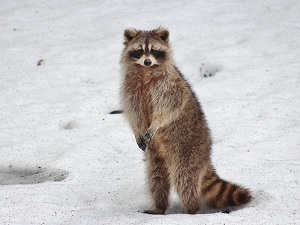

In [96]:
filename = '/content/drive/My Drive/Paridhi_Colab/Internal_lab_13sept/test_image.jpg'
unscaled = cv2.imread(filename) # Original image for display

In [97]:
unscaled.shape

(225, 300, 3)

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [98]:
image_height, image_width, _ = unscaled.shape
image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE)) # Rescaled image to run the network
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

### Predict the coordinates of the bounding box for the given test image

In [99]:
region = model.predict(x=np.array([feat_scaled]))[0] # Predict the BBox

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

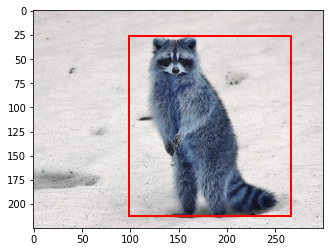

In [100]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()